In [ ]:
################################################ 
################################################  
#     / ____// /    / ____/ |/ //_  __// / / / #
#    / /_   / /    / __/  |   /  / /  / /_/ /  #
#   / __/  / /___ / /___ /   |  / /  / __  /   #
#  /_/    /_____//_____//_/|_| /_/  /_/ /_/    #
################################################                                         
################################################                                 
                                                              
# WELCOME TO FLEXTH - THE FLOOD EXTENT ENHANCEMENT AND WATER DEPTH ESTIMATION 
# TOOL FOR (SATELLITE-DERIVED) INUNDATION MAPS

# The tool enhances flood delineation maps (e.g. satellite-derived) by extending 
# floods based on terrain topography and additional optional information. 
# The algorithm employs topographical data (in the form of a DTM) 
# in combination with flood delineations to provide water depth estimates.
# The algorithm requires, as a primary input, a flood delineation map and a DTM. 
# Additional information may include areas excluded from flood mapping (i.e. no data)
# and/or permanent water bodies. 
# Input delineations must be provided via binary (i.e. 0/1) georeferenced rasters 
# (GeoTIFF) in a suitable PROJECTED reference system.
# Since water depth is the primary proxy for flood damages, the tool aims to facilitate
# flood impact assessment over large scales with minimum supervision and computational times.
# 
# The script 'DTM_2_floodmap.py' helps to easily bring your DTM (or any other input) into 
# the same extent,  resolution, grid and projections  as the input flood map raster.

# For further details see: 
#'Water depth estimate and flood extent enhancement for satellite-based inundation maps' 
# by Betterle and Salamon (2024) on Natural Hazards and Earth System Sciences, 
# https://doi.org/10.5194/nhess-24-2817-2024,
#
# visit https://code.europa.eu/floods/floods-river/flexth
#
# or contact andrea.betterle@ec.europa.eu or peter.salamon@ec.europa.eu


##############################################################################
##############################################################################
##############################################################################





import numpy as np
import rasterio
import cv2
from astropy.convolution import convolve
import warnings
import os, glob
import time
from pathlib import Path
from scipy.spatial import cKDTree





######################
#INPUTs and PARAMETERS 
######################


#   INPUT
#   a folder named 'input_dir'  must contain the following maps in a suitable PROJECTED reference system :
    
#   flood.tif            :   binary map delineating flooded areas (0: no flood; 1:flood)
#   dtm.tif              :   digital terrain model
#   exclusion.tif        : * binary map delineating areas excluded from flood mapping (0: no mask; 1:mask (i.e. no-data))
#   permanent_water.tif  : * binary map delineating permanent/seasonal water bodies (0: no water; 1:water)
#   obswater.tif         : * binary map delineating all observed water (union between flood and permanent_water) - to be used if permanent_water.tif is not provided (0: no water; 1:water)
#   (*:  optional input)
#
#  OUTPUT
#  output files generataed by FLEXTH:
#
#  WD.tif :  flood extent with water depth estimates (in cm)
#  WL.tif :  flood extent with water level estimates (in the vertical coordinate of the DTM, typically m a.s.l.)
#
#
#  Below, all variable whose names start with "param" denote adjustable parameters.
#  The most relevant are listed below whereas throughout the codes there are 
#  additional less sensitive and more geeky ones. Testing showed that the 
#  default values are effective and robust in a wide range of settings. 
#  Nonetheless, parameters can be tweaked to match specific needs and/or use cases.
#  Parameters may require adjustments for resolutions larger/smaller than 20 m and/or 
#  depending on the accuracy of the flood delineation and/or of the DTM


# TILING
# If param_tiling = True, the inputs are tiled and FLEXTH is run in sequence across the tiles. 
# The tiled rasters are stored in the authomatically created subfolder "input_tiled".
# Tiling can be necessary for analysis on large rasters (or high resolutions) when computational resources are limited.
# Smaller tiles use less resources but might generate some artifacts in flooded areas across the borders of the tiles. 
#
# If you want to run FLEXH in tiling mode, set BOTH 'param_tiling=True' AND 'param_tile_inputs=True' during the first run. 
# If you  want to re-run FLEXTH (without the need to re-tile the inputs) you can set 'param_tile_inputs=False'. 

param_tiling      = False   # True to run FLEXTH on the tiled inputs
param_tile_inputs = True    # True to tile the inputs. If input is already tiled, select False. Relevant if "param_tiling = True"
param_tile_size   = 10000   # size of the squared tiles (pixels)
param_merge_tiles = True    # True to automatically merge the tiled outputs in the end


# Select the output that will be generated: Water depth ("WD") , Water level ("WL"), both ("WL_WD")
param_output_map = 'WL_WD'


input_dir  = Path(r'C:/Users/Stanislav/OneDrive/Pulpit/Data Science and Licencjat/Licencjat/FLEXTH/testowanie/input' )
output_dir = Path(r'C:/Users/Stanislav/OneDrive/Pulpit/Data Science and Licencjat/Licencjat/FLEXTH/testowanie/output' )



# WATER LEVEL ESTIMATION METHOD (options: 'method_A', 'method_B'): 
param_WL_estimation_method = 'method_A'  




###############
# PARAMETERS ##
###############
#see the 'Parameters' section in https://code.europa.eu/floods/floods-river/flexth for more details 

# --code name ----------------------- value---- name -- range ---- default- units -- description---------------------------------------
param_threshold_slope               =  0.1     # S_max [0, 1]        {0.1}  (-)  : border pixels steeper than this (D_z/D_x) are not used to estimate water level
param_size_gaps_close               =  0.1     # A_g   [0, 1]        {0.1}  (km2): gaps up to this size in the initial flood map will be closed

param_max_number_neighbors          =  200     # N_max [1, 1000]     {200}  (-):   number of border pixels used to compute water level at each location
param_inverse_dist_exp              =  1       # alpha [0, 5]        {1}    (-):   inverse distance weighting exponent used to interpolate WL inside flooded areas 
param_border_subsampling            =  0       # Sbs_r [0, 100]:     {0}    (-):   parameter tuning the subsampling rate of border pixels in large flooded areas

param_min_flood_border_size         =  10      # N_min [1, 1000]     {10}   (-):   if the number of valid pixels along the border is less than this, WL is estimated based on the distribution of the elevation of the pixels inside the flooded area
param_border_quantile               =  0.5     # P     [0, 1]        {0.5}  (-):   assign water level based on the quantile P of the elevation of border cells (valid if Method B is selected)
param_inner_quantile                =  0.98    # P*    [0, 1]        {0.98} (-):   in flooded areas with less that N_min valid border pixels, uses this quantile of the elevation of the pixels inside the flooded area to estimate water level

param_spread_outside_exclusion_mask = False    #Sprd   [True, False] {False}(-):   if True, flood propagation is performed also outside the exclusion mask (i.e. outside no-data areas) 
param_max_propagation_distance      = 10       # D_max [0, 100]      {10}   (km):  maximum propagation distance for an arbitrarily large flooded area
param_distance_range                = 10       # A_1/2 [0, 100]      {10}   (km2): flooded areas of this size can reach half of the maximum propagation distance  
    
param_WD_star                       = 10       # WD*   [0, 100]:     {10}   (cm) : dummy water depth assigned where estimated WL is below ground surface (i.e WL < DTM) 




#######################################################################################
#######################################################################################
## END INPUT - NO NEED TO MODIFY ANYTHING AFTER THIS POINT (UNLESS YOU HAVE GOOD IDEAS)
#######################################################################################
#######################################################################################



##############
#FUNCTIONS######
##################

#TILES INPUT_RASTER INTO OUTPUT_DIR
def tiling(input_raster, source_dir, param_tile_size):
    from rasterio.windows import Window
    
    file_name     = os.path.splitext(os.path.basename(input_raster))[0]
    output_folder = source_dir / 'input_tiled'
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Open the GeoTIFF file
    with rasterio.open(input_raster) as src:
        # Get the raster size
        rastersize_width, rastersize_height = src.width, src.height
    
        # Calculate the number of tiles in x and y directions
        num_tiles_x = (rastersize_width  + param_tile_size - 1) // param_tile_size
        num_tiles_y = (rastersize_height + param_tile_size - 1) // param_tile_size
    
        # Loop through each tile and extract it from the original raster
        for i in range(num_tiles_x):
            for j in range(num_tiles_y):
                # Calculate the tile's bounding box
                x_off = i * param_tile_size
                y_off = j * param_tile_size
                x_size = min(param_tile_size, rastersize_width  - x_off)
                y_size = min(param_tile_size, rastersize_height - y_off)
    
                # Create a window object for the tile
                window = Window(x_off, y_off, x_size, y_size)
    
                # Read the tile from the original raster
                tile_data = src.read(1, window=window)
    
                # Create a new GeoTIFF file for the tile
                tile_profile = src.profile
                tile_profile.update({
                    'width': x_size,
                    'height': y_size,
                    'transform': rasterio.windows.transform(window, src.transform),
                    'compress': 'deflate'
                })
                with rasterio.open(output_folder/f'{file_name}_tile_{i+1}_{j+1}.tif', 'w', **tile_profile) as dst:
                    dst.write(tile_data, 1)
    
    
    
#  identifies the indices of neighboring cells in an array 
#  i,j : indices of the target location; 
#  n_row and n_col:  number or rows and columns of the  target array 
#  connectivity: type of connectivity to use (4 , 8)
 
def ij_neighbors(i,j,n_row,n_col,connectivity):  
    if connectivity == 4:
        neighbors=np.array([ [i-1,j], [i,j+1], [i+1,j],  [i,j-1]])    
    elif connectivity == 8:
        neighbors=np.array([[i-1,j-1],[i-1,j], [i-1,j+1], [i,j+1], [i+1,j+1], [i+1,j], [i+1,j-1], [i,j-1]])  
    elif connectivity == 24:
        neighbors=np.array([[i-2, j-2],[i-2, j-1], [i-2,j], [i-2,j+1], [i-2,j+2], [i-1, j-2], [i-1,j-1], [i-1,j], [i-1,j+1], [i-1,j+2], [i,j-2], [i,j-1], [i,j+1], [i,j+2], [i+1,j-2], [i+1,j-1], [i+1,j], [i+1,j+1],[i+1,j+2],[i+2,j-2],[i+2,j-1], [i+2,j], [i+2,j+1], [i+2,j+2]  ]     ) 
    else:
        raise ValueError(f"Unsupported connectivity value: {connectivity}")
    
    for indice in range(len(neighbors)):
        if neighbors[indice,0]> n_row-1 or neighbors[indice,0]<0 :
            neighbors[indice,0]=i
            neighbors[indice,1]=j
        if neighbors[indice,1]> n_col-1 or neighbors[indice,1]<0 :
            neighbors[indice,0]=i
            neighbors[indice,1]=j                     
            
    return neighbors.astype('uint32')    
   
    

# FUNCTION THAT COMPUTES THE WEIGHTED QUANTILES OUT OF A PDF
def weighted_quantile(values, percentile, weights=None):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: 
    :computes one percentile across the columns of a 2d array
    :percentile should be in [0, 1]!
    :param values: numpy.array with data
    :param percentile: the value of the quantile
    :param sample_weight: array-like of the same length as `array`
    :return: numpy.array with computed percentile for each row of data.
    """
    values = np.array(values)
    percentile = np.array(percentile)
    if weights is None:
        weights= np.ones(np.shape(values))
    weights = np.array(weights)
    assert np.all(percentile >= 0) and np.all(percentile <= 1), /
        'percentile should be in [0, 1]'

    sorter = np.argsort(values)
    values = np.take_along_axis(values, sorter, axis = 1)   
    weights = np.take_along_axis(weights, sorter, axis = 1)      

    weighted_quantiles  = np.cumsum(weights, axis = 1 ) - 0.5 * weights
    weighted_quantiles /= np.sum(weights, axis = 1)[:, np.newaxis] * np.ones ( np.shape(weighted_quantiles))
    
    return values [np.array( np.arange(0,np.shape(values)[0],1)  ), np.argmin( (weighted_quantiles - percentile  )**2, axis = 1) ] 


##################
##################
# MAIN FUNCTION ##
##################
##################

def flood_processing(flood_path, dtm_path, exclusion_path, obswater_path, permanent_water_path):
           
    # IMPORT FLOOD MAP AND DTM
    with rasterio.open(flood_path) as src:
        flood     = src.read(1).astype('uint8')
        flood[(flood !=1) & (flood !=0)]  = 0
        transform = src.transform
        crs       = src.crs

    with rasterio.open(dtm_path) as src:
        dtm           = src.read(1)
        transform_dtm = src.transform
        crs_dtm       = src.crs
        dtm_nodata    = src.nodata
        dtm[dtm == dtm_nodata]  = np.nan
    
    
    #RISE AN ERROR IF THE SPATIAL REFERENCES ARE NOT MATCHING
    if transform != transform_dtm or crs != crs_dtm:
        raise TypeError("Flood map and DTM don't share the same projections and/or grid!")
    
    
    
    #CHECKS IF OPTIONAL INPUTS ARE PROVIDED AND IMPORT THEM
    if os.path.isfile(exclusion_path):
        with rasterio.open(exclusion_path) as src:
            exclusion           = src.read(1).astype('uint8')
            exclusion[(exclusion !=1) & (exclusion !=0)] = 1 
            transform_exclusion = src.transform
            crs_exclusion       = src.crs
    
            if transform != transform_exclusion or crs  != crs_exclusion:
                raise TypeError("Flood map and exclusion mask don't share the same projections and/or grid!")
    else:
        exclusion  = np.full_like(flood, 0)
        

    if os.path.isfile(obswater_path):
        with rasterio.open(obswater_path) as src:
            obswater           = src.read(1).astype('uint8')
            obswater[(obswater !=1) & (obswater !=0)]  = 0
            transform_obswater = src.transform
            crs_obswater       = src.crs
            
            if transform != transform_obswater or crs  != crs_obswater:
                raise TypeError("Flood map and observed water don't share the same projections and/or grid!")
                
                
    else:
        obswater  = np.copy(flood)   
    

    if os.path.isfile(permanent_water_path):
        with rasterio.open(permanent_water_path) as src:
            permanent_water           = src.read(1).astype('uint8')
            permanent_water[(permanent_water !=1) & (permanent_water !=0)]   = 0
            transform_permanent_water = src.transform
            crs_permanent_water       = src.crs
            
            if transform != transform_permanent_water or crs  != crs_permanent_water:
                raise TypeError("Flood map and permanent water don't share the same projections and/or grid!")            
            
    else:
        permanent_water  = np.full_like(flood, 0)    

    


    #GEOTRANFORMATION
    transform*(0,0)                # goes from COL-ROW index to X-Y:  trans*(ncol,nrow)=(x_coordinate,y_coordinate)
    n_row, n_col    = flood.shape  #extract the dimension of the raster
    L = transform.a                # pixel size in m (pixels should be squared)
     
    #LOCAL SLOPE
    slope_max =  np.gradient(dtm, L)
    slope_max =  np.sqrt(slope_max[0]**2 + slope_max[1]**2 )   
    
    #IDENTIFIES WHERE SLOPE IS BEYOND THE THRESHOLD 
    slope_steep   =   np.array(slope_max >  param_threshold_slope).astype('uint8')
    
    
    #############################################################################
    ##CONNECTED COMPONENTS ANAYSIS WITH CV2 - IDENTIFIES CONTIGUOUS FLOODED AREAS        
    #############################################################################  
    
    #SOME KERNELS 
    kernel_1       = np.ones((3,3),np.uint8)
    kernel_1_cross = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype = np.uint8)
    kernel_2       = np.ones((5,5),np.uint8)
    
    #RUNS MORPHOLOGICAL CLOSING TO REMOVE SMALL HOLES AND VERY IRREGULAR BORDERS FROM FLOOD AND OBSWATER
    flood    = cv2.morphologyEx(flood   ,    cv2.MORPH_CLOSE, kernel_1_cross,  iterations = 2 )
    obswater = cv2.morphologyEx(obswater,    cv2.MORPH_CLOSE, kernel_1_cross,  iterations = 2 )
     
    #DILATE EXCLUSION MASK
    exclusion = cv2.dilate(exclusion  ,  kernel_1)
    

    #############################################
    #CLOSES SMALL HOLES IN FLOOD MAP WITH  CV2 ##
    #############################################
    print ('Closing small gaps in flood map...')
    
    threshold_n_pixels                           = int(param_size_gaps_close*1e6 / L**2)
    binary_map_complementary_flood               = np.logical_not(flood).astype('uint8')
    z_num_labels, z_labels, z_stats, z_centroids = cv2.connectedComponentsWithStats(binary_map_complementary_flood,connectivity=8) 

    for i in range(len(z_stats)):
        if np.abs(z_stats[i,4]) < threshold_n_pixels:
            flood    [ z_stats[i,1]: z_stats[i,1] + z_stats[i,3] , z_stats[i,0]:z_stats[i,0] + z_stats[i,2] ] [z_labels[ z_stats[i,1]: z_stats[i,1] + z_stats[i,3] , z_stats[i,0]:z_stats[i,0] + z_stats[i,2] ] ==i] = 1
            obswater [ z_stats[i,1]: z_stats[i,1] + z_stats[i,3] , z_stats[i,0]:z_stats[i,0] + z_stats[i,2] ] [z_labels[ z_stats[i,1]: z_stats[i,1] + z_stats[i,3] , z_stats[i,0]:z_stats[i,0] + z_stats[i,2] ] ==i] = 1
    
    
    if os.path.isfile(input_dir / 'permanent_water.tif'):
        permanent_water = cv2.morphologyEx(permanent_water,    cv2.MORPH_CLOSE, kernel_1_cross,  iterations = 2 )
        
    else:
        permanent_water = obswater - flood
        permanent_water[(permanent_water!=0) & (permanent_water!=1) ] = 0
    


    # Applying cv2.connectedComponents() - possibly change the connectivity type 
    # !! opencv with connectivity = 4 may have problems in some versions of the package better use connectivity = 8 !!!!
    # z_stats contains: [xtop, ytop, xwidth, ywidth, #pixels] - first element of stats correspondes to background value (i.e. 0)
    
    z_num_labels, z_labels, z_stats, z_centroids = cv2.connectedComponentsWithStats(flood,connectivity=8)   
    
    flood_dilated           =   cv2.dilate(flood           ,  kernel_1)
    flood_eroded            =   cv2.erode (flood           ,  kernel_1_cross)
     
    exclusion_dilated       =   cv2.dilate(exclusion       ,  kernel_1)

    permanent_water_dilated =   cv2.dilate(permanent_water ,  kernel_1)
    
    
    flood_border           =   flood_dilated    - flood_eroded 
    flood_border_inner     =   flood            - flood_eroded
     
    slope_steep_dilated      =   cv2.dilate(slope_steep  ,  kernel_1)
    
    exclusion_dilated      [ (exclusion       ==0)  & (exclusion_dilated       ==1) & (flood==0) & (flood_dilated==1)] = 0
    permanent_water_dilated[ (permanent_water ==0)  & (permanent_water_dilated ==1) & (flood==0) & (flood_dilated==1)] = 0
    slope_steep_dilated    [ (slope_steep     ==0)  & (slope_steep_dilated     ==1) & (flood==0) & (flood_dilated==1)] = 0
    
    
    flood_border          =     flood_border *  np.logical_not( exclusion_dilated )   *  np.logical_not( permanent_water_dilated)   *    np.logical_not(slope_steep_dilated)  
    
    dtm_border_flood      =   dtm * flood_border
      
   
    ## AVERAGES THE DEM ALONG THE BORDER 
    dtm_border_flood_smooth= convolve ( dtm_border_flood, kernel_2, mask = flood_border == 0, preserve_nan = True )
    dtm_border_flood_smooth[flood_border==0] = np.nan     
    
    
    flood_border =   flood_border * flood_border_inner


    #######################################################
    #######################################################
    ## WATER LEVEL ESTIMATION IN INITIALLY FLOODED AREAS ##
    #######################################################
    #######################################################

    z_water_level = np.full([n_row,n_col], np.nan, dtype='float32')
    
    ROW, COL   =  np.mgrid[0:n_row,0:n_col].astype('uint32')
    
    row_flood                          =   np.ma.masked_array(ROW,      z_labels==0).compressed()
    col_flood                          =   np.ma.masked_array(COL,      z_labels==0).compressed()
    flood_labels_compressed            =   np.ma.masked_array(z_labels, z_labels==0).compressed()
        
    row_flood_border                   =   np.ma.masked_array(ROW,                     flood_border==0).compressed()
    col_flood_border                   =   np.ma.masked_array(COL,                     flood_border==0).compressed()
    flood_borders_labels_compressed    =   np.ma.masked_array(z_labels,                flood_border==0).compressed()
    dtm_border_flood_smooth_compressed =   np.ma.masked_array(dtm_border_flood_smooth, flood_border==0).compressed()


    param_border_subsampling_sill       =  100000       # Sbs_s [10, +inf]: maximum number of pixels along the border of a single flooded area used by FLEXTH to estimate water level 

    #  ASSIGNS WATER LEVELS TO INITIAL FLOODED AREAS BASED ON THE DTM VALUES ALONG THE BORDERS
    #  OF FLOODED AREAS THAT ARE NOT CONTIGUOUS WITH THE EXCLUSION MASK
    print('Assigning water elevation to initial flooded areas...')
    
    for i in range (1,len(z_stats)):

        temp_position_flood           =  np.stack( ( row_flood[flood_labels_compressed==i],col_flood[flood_labels_compressed==i]),axis = 1)
        temp_position_border          =  np.copy(  np.stack( ( row_flood_border[flood_borders_labels_compressed==i],col_flood_border[flood_borders_labels_compressed==i]),axis = 1))
        temp_dtm_border_flood_smooth  =  np.copy( dtm_border_flood_smooth_compressed[flood_borders_labels_compressed==i])
        
        len_border  = len(temp_position_border)


        # if the number of valid border pixels is less than "param_min_flood_border_size" uses the statistics of the DTM inside the flooded area
        if  len_border < param_min_flood_border_size: 
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                z_water_level[temp_position_flood[:,0], temp_position_flood[:,1] ]  =  np.nanquantile(dtm[temp_position_flood[:,0], temp_position_flood[:,1] ], param_inner_quantile)
    
        else:   
            
            #SUBSAMPLING OF THE BORDER
            tt                            = len_border / param_border_subsampling_sill
            param_border_subsampling_     = 2 - param_border_subsampling 
            param_border_subsampling_     = param_border_subsampling_ if param_border_subsampling_ != 0  else (param_border_subsampling_ + 0.0001)
            border_sampling               = len_border / ( param_border_subsampling_sill/param_border_subsampling_ * ( 1 + tt - np.sqrt( (tt +1)**2  -2*param_border_subsampling_*tt )  )   ) 
            
            temp_position_border          = temp_position_border[::np.round(border_sampling).astype(int)]
            temp_dtm_border_flood_smooth  = temp_dtm_border_flood_smooth[::np.round(border_sampling).astype(int)]
            
            len_border                    = len(temp_position_border)

            
            # BUILD A CKDTREE FOR EACH SET OF POINTS
            tree_BORDER = cKDTree(temp_position_border)
    
            param_workers_cKDTree =  8
            distances, indices = tree_BORDER.query(temp_position_flood, k=param_max_number_neighbors,workers = param_workers_cKDTree)

            distances = distances.astype('float32')
            distances[distances==0]  = 1
            indices   = indices.astype('uint32')


            if distances.ndim == 1:
                distances = np.expand_dims(distances, axis=1)
                indices   = np.expand_dims(indices, axis=1)

            if param_max_number_neighbors > len_border:
                indices   = indices  [:, :len_border]
                distances = distances[:, :len_border]


            
            #####################
            ## CHOOSE THE WEIGHTS
            #####################
                
            # inverse distance weighting IDW
            weights  =   1 / (distances ** param_inverse_dist_exp).astype('float32')


            #####################################
            ## choose WL estimation method A vs B
            #####################################

            if param_WL_estimation_method == 'method_A':
            #METHOD A : water level is interpoleated using IDW or EDW weights
                dtm_temp_statistic    =  (np.sum((temp_dtm_border_flood_smooth[indices] * weights).astype('float32'), axis = 1 )  / np.sum( weights , axis = 1 ) ).astype('float32')
                
                
            elif param_WL_estimation_method == 'method_B':
                #METHOD B : water level is a distence-weighted QUANTILE of all closest dtm neighboring cells 
                dtm_temp_statistic    =   weighted_quantile(temp_dtm_border_flood_smooth[indices], param_border_quantile, weights  =  weights)
                             
                    
            z_water_level[temp_position_flood[:,0], temp_position_flood[:,1]]    =    dtm_temp_statistic 
            #plt.imshow(z_water_level, interpolation = 'none', vmin=50, vmax=100)
    
    
    

    ###############
    #################
    ##FLOOD EXPANSION
    ###################
    #####################

    z_water_level_augmented = np.copy(z_water_level)
    
    if os.path.isfile(exclusion_path) or param_spread_outside_exclusion_mask : 
        print('Augmenting flooded areas...')
        
        if param_spread_outside_exclusion_mask == True :
            exclusion = np.full_like(exclusion, 1)

        param_connectivity                 =  8         # <<INPUT connectivity used to spread flooded areas (4 or 8)
    
        z_water_level_masked_compressed         =   np.ma.masked_array(z_water_level, flood_border_inner==0).compressed() 
        z_water_level_masked_compressed_initial =   np.ma.masked_array(z_water_level, flood_border_inner==0).compressed()
        row_flood_border                        =   np.ma.masked_array(ROW,           flood_border_inner==0).compressed()
        col_flood_border                        =   np.ma.masked_array(COL,           flood_border_inner==0).compressed()
        flood_labels_border                     =   np.ma.masked_array(z_labels,      flood_border_inner==0).compressed()
        
        FLOOD = np.array ( [flood_labels_border,  row_flood_border,  col_flood_border,  z_water_level_masked_compressed, z_water_level_masked_compressed_initial ]  ).T
        
        #SORTS BASED ON DECREASING WATER ELEVATION
        FLOOD_sort_descending= np.flipud(FLOOD[FLOOD[:, 3].argsort()])
        
        #SIZE OF INITIAL FLOODED AREAS IN M2
        dim_flooded_area = z_stats[:,4] * L**2
        dim_flooded_area[dim_flooded_area<0]=0  #  prevents potential negative values caused by overflow 
        
        
        ########################
        # MAX EXPANSION DISTANCE  
        ########################
       
        ##EXPONENTIAL PARAMETRIZATION OF MAX PROPAGATION DISTANCE
        threshold_distance = param_max_propagation_distance * 1000   *  ( 1 -   pow(2,   -  dim_flooded_area   / (param_distance_range * 1e6  )  )        )
        
        #avoids singularities in case no flood expansion is set
        threshold_distance = threshold_distance + 1
        
        FLOOD_sort_descending_list= list (FLOOD_sort_descending)
          
        z_water_level_augmented = np.copy(z_water_level)
        
        z_labels_augmented      = np.copy(z_labels)
        temp_dist_from_border   = np.zeros(z_labels.shape, dtype = 'float16')
        
        
        i=0
        i_counter  =  len ( FLOOD_sort_descending_list )
        i_stop     =  len ( FLOOD_sort_descending_list )
        total_processed = 0
        
 
        while i < i_counter: 
            
            if i == i_stop:
                FLOOD_sort_descending = np.vstack(FLOOD_sort_descending_list)
                FLOOD_sort_descending = FLOOD_sort_descending[i_stop: ,:]
                FLOOD_sort_descending = np.flipud(FLOOD_sort_descending[FLOOD_sort_descending[:, 3].argsort()]) 
                FLOOD_sort_descending_list= list (FLOOD_sort_descending)
                i=0
                i_stop    = len(FLOOD_sort_descending)
                i_counter = len(FLOOD_sort_descending) 
        
        
            vicini =  ij_neighbors(FLOOD_sort_descending[i,1], FLOOD_sort_descending[i,2] , n_row, n_col, param_connectivity)  
             
            label     = FLOOD_sort_descending[i,0].astype('uint32')
            
            initial_wl= FLOOD_sort_descending[i,4]  
        
        
    
            temp_= ( L +  temp_dist_from_border[FLOOD_sort_descending[i,1].astype('uint32'), FLOOD_sort_descending[i,2].astype('uint32')]  ) / threshold_distance[label]
            
            wl = (  initial_wl  -  ( initial_wl  - dtm[vicini[:,0],vicini[:,1]]   )  * temp_  )     * np.heaviside(1-temp_ , 0 )   +    dtm[vicini[:,0],vicini[:,1]]  *     (  1- np.heaviside(1-temp_ , 0 )    )
           
            wl[wl>FLOOD_sort_descending[i,3]] = FLOOD_sort_descending[i,3]
            
            
            condition =  (   
                
                         np.heaviside( (exclusion[vicini[:,0],vicini[:,1]] > 0)  + (obswater[vicini[:,0],vicini[:,1]] > 0) + (permanent_water[vicini[:,0],vicini[:,1]] > 0)   , 0).astype('bool')          # 1. must be in the exlusion or permanent water layer
    
                       * ( dtm[vicini[:,0],vicini[:,1]] <  (wl-0.01) ) # FLOOD_sort_descending[i,3] #  z_flooded_areas_augmented[i][2]                   # 2. dtm must be lower than the corresponding water level    
                     
                       * np.heaviside(  np.isnan( z_water_level_augmented[vicini[:,0],vicini[:,1]])         , 0  ).astype('bool')                        # 3. must be nodata (i.e. not alreay assigned)
    
                         )
        
           
            temp_dist_from_border[vicini[:,0][condition],vicini[:,1][condition]]    = L * np.array([1.414, 1, 1.414, 1, 1.414, 1, 1.414, 1])[condition]     + temp_dist_from_border[FLOOD_sort_descending[i,1].astype('uint32'), FLOOD_sort_descending[i,2].astype('uint32')]
            
            z_water_level_augmented[vicini[:,0][condition],vicini[:,1][condition]]  =  wl[condition]   
            
            FLOOD_sort_descending_list.append  (  np.array([ label*(condition[condition]) ,  vicini[:,0][condition],  vicini[:,1][condition]  ,  wl[condition] , initial_wl*(condition[condition])  ]).T  ) 
            
            z_labels_augmented[vicini[:,0][condition],vicini[:,1][condition]]  =  label 
            
            i_counter+= np.sum(condition)
                        
                                 
            i+=1 
            
            #print(i)
            total_processed +=1
        
    
    
        ##############################
        ## SMOOTHING EXPANDED WL ####
        ##############################
        print('Smoothing... /n')
               
        param_number_smoothings      = 20   #<<<<<<  INPUT - how many smoothing iterations 
        
        
        z_water_level_augmented_initial = np.copy(z_water_level_augmented)
        z_water_level_augmented[ np.isnan(z_water_level_augmented_initial) ] = dtm[  np.isnan(z_water_level_augmented_initial)  ]
        
        target_i, target_j  =  np.where( (~np.isnan(z_water_level_augmented_initial)) & (flood == 0) )
        target_i = target_i.astype(np.int32) ; target_j = target_j.astype(np.int32)
        
        
        connectivity = 24      #<<<<<<  INPUT - size of the smoothing kernel (24 is a 5x5 box kernel, 8 is a 3x3 box kernel)
        
        neighbors_i = np.zeros((target_i.shape[0], connectivity)).astype(np.uint32)
        neighbors_j = np.zeros((target_i.shape[0], connectivity)).astype(np.uint32)
        
          
        for i in range(target_i.shape[0]):
            
            neighbors = ij_neighbors(target_i[i], target_j[i], n_row, n_col, connectivity)
            neighbors_i[i, :] = neighbors[:, 0]
            neighbors_j[i, :] = neighbors[:, 1]
                    
        
        mask_1 = np.where(~np.isnan(z_water_level))

        
        for v in range(param_number_smoothings):
            z_water_level_augmented[target_i,target_j] = np.mean(z_water_level_augmented[neighbors_i,neighbors_j], axis = 1 )
            z_water_level_augmented[ mask_1]           = z_water_level[  mask_1  ]
        
        z_water_level_augmented[ np.isnan(z_water_level_augmented_initial) ] = np.nan
        

    else:
        z_water_level_augmented = np.copy(z_water_level)

    

    ###############
    # WATER DEPTH #
    ###############
    WD                        = ( ( z_water_level_augmented - dtm ) * 100  ).astype('float32')   
    WD[WD<0] = 0 
    WD[WD > 0]                = WD[WD > 0] + param_WD_star
    WD[(WD==0) & (flood>0)  ] = param_WD_star
    
    #dummy water depth assigned to permanent water bodies
    WD[permanent_water==1] = 9999 
    WD[np.isnan(WD)] = 0
    
    
    
    ############
    # WL LEVEL #
    ############
    WL          = ( z_water_level_augmented   ).astype('float32')   
    WL[WD > 0]  = WL[WD > 0] + param_WD_star/100
    WL[WD==0 ]  = np.nan
    
    #DUMMY WATER LEVEL ASSIGNED TO PERMANENT WATER BODIES
    WL[permanent_water==1] = 9999 
    

    ########
    ##SAVING
    ########
    
    print('Saving... /n')
    
    prefix  = os.path.splitext(os.path.basename(flood_path))[0]
    
    if param_output_map == "WD" or  param_output_map == "WL_WD" :
    
        with rasterio.open(
            output_dir / f'WD_{prefix}_{param_WL_estimation_method}_Smax_{param_threshold_slope}_Nmax_{param_max_number_neighbors}_a_{param_inverse_dist_exp}_Sbs_{param_border_subsampling}_Dmax_{param_max_propagation_distance}_A12_{param_distance_range}_gaps_{param_size_gaps_close}_unrestricted_{param_spread_outside_exclusion_mask}.tif',
            mode="w",
            driver="GTiff",
            compress='deflate',
            height=n_row,
            width=n_col,
            count=1,
            dtype=rasterio.uint16,
            crs=crs,
            transform=transform,
            nodata= 0
            ) as water_depth:
                water_depth.write(WD, 1)
                
                
    if param_output_map == "WL" or  param_output_map == "WL_WD" :
    
        with rasterio.open(
            output_dir / f'WL_{prefix}_{param_WL_estimation_method}_Smax_{param_threshold_slope}_Nmax_{param_max_number_neighbors}_a_{param_inverse_dist_exp}_Sbs_{param_border_subsampling}_Dmax_{param_max_propagation_distance}_A12_{param_distance_range}_gaps_{param_size_gaps_close}_unrestricted_{param_spread_outside_exclusion_mask}.tif',
            mode="w",
            driver="GTiff",
            compress='deflate',
            height=n_row,
            width=n_col,
            count=1,
            dtype=rasterio.float32,
            crs=crs,
            transform=transform,
            ) as water_level:
                water_level.write(WL, 1)
    
   
    
    print('Finish ! /n')
      
        
########        
## RUN ! 
########     
  
if __name__ == '__main__':
    
    
    start = time.time()  
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    
    if param_tiling == True: 
       
        #TILES ALL THE INPUTS IF PARAM_TILE_INPUTS IS TRUE 
        if param_tile_inputs == True:             
            print('Tiling the input rasters...')
            
            tiling(input_dir / 'flood.tif' , input_dir, param_tile_size)
            
            tiling(input_dir / 'dtm.tif'   , input_dir, param_tile_size)
            
            if os.path.isfile(input_dir / 'exclusion.tif'):
                tiling(input_dir / 'exclusion.tif' , input_dir, param_tile_size)
                
            if os.path.isfile(input_dir / 'obswater.tif'):
                tiling(input_dir / 'obswater.tif' , input_dir, param_tile_size)
                
            if os.path.isfile(input_dir / 'permanent_water.tif'):
                tiling(input_dir / 'permanent_water.tif' , input_dir, param_tile_size)
            

    
        input_list_flood = glob.glob( str(input_dir/"**/*flood_tile*.tif")  , recursive=True)
       
        for index, flood_path in enumerate(input_list_flood):
            
            print(f'Processing tile {index+1} out of {len(input_list_flood)}')
            
            dtm_path             =  flood_path.replace("flood_tile", "dtm_tile") 
            exclusion_path       =  flood_path.replace("flood_tile", "exclusion_tile") 
            obswater_path        =  flood_path.replace("flood_tile", "obswater_tile")  
            permanent_water_path =  flood_path.replace("flood_tile", "permanent_water_tile") 
    
    
            flood_processing(flood_path           = flood_path ,
                             dtm_path             = dtm_path  , 
                             exclusion_path       = exclusion_path ,
                             obswater_path        = obswater_path , 
                             permanent_water_path = permanent_water_path )   

       
        
        
    else:
        flood_processing(flood_path           = input_dir / 'flood.tif' ,
                         dtm_path             = input_dir / 'dtm.tif'   , 
                         exclusion_path       = input_dir / 'exclusion.tif' ,
                         obswater_path        = input_dir / 'obswater.tif' , 
                         permanent_water_path = input_dir / 'permanent_water.tif' )        
    
    
    #MERGE WD AND WL TILES
    if param_tiling == True and param_merge_tiles == True:
        
        tiles_to_merge_WD = glob.glob( str(output_dir/"*WD_flood_tile*.tif")  , recursive=True)
        tiles_to_merge_WL = glob.glob( str(output_dir/"*WL_flood_tile*.tif")  , recursive=True)
    
        inputs = [rasterio.open(f) for f in tiles_to_merge_WD]
        merged_image, out_trans = rasterio.merge.merge(inputs)

        with rasterio.open(output_dir / f'WD_merge_{param_WL_estimation_method}_Smax_{param_threshold_slope}_Nmax_{param_max_number_neighbors}_a_{param_inverse_dist_exp}_Sbs_{param_border_subsampling}_Dmax_{param_max_propagation_distance}_A12_{param_distance_range}_gaps_{param_size_gaps_close}_unrestricted_{param_spread_outside_exclusion_mask}.tif', 
                           'w', 
                           driver='GTiff',
                           height=merged_image.shape[1], 
                           width=merged_image.shape[2], 
                           count=1, 
                           dtype=merged_image.dtype, 
                           crs=inputs[0].crs, 
                           nodata = inputs[0].nodata,
                           transform=inputs[0].transform,
                           compress='deflate')  as dst:
            dst.write(merged_image[0,:,:], 1)
        
        for input in inputs:
            input.close()
        
        
    
        inputs = [rasterio.open(f) for f in tiles_to_merge_WL]
        merged_image, out_trans = rasterio.merge.merge(inputs)

        with rasterio.open(output_dir / f'WL_merge_{param_WL_estimation_method}_Smax_{param_threshold_slope}_Nmax_{param_max_number_neighbors}_a_{param_inverse_dist_exp}_Sbs_{param_border_subsampling}_Dmax_{param_max_propagation_distance}_A12_{param_distance_range}_gaps_{param_size_gaps_close}_unrestricted_{param_spread_outside_exclusion_mask}.tif', 
                           'w', 
                           driver='GTiff',
                           height=merged_image.shape[1], 
                           width=merged_image.shape[2], 
                           count=1, 
                           dtype=merged_image.dtype, 
                           crs=inputs[0].crs, 
                           nodata = inputs[0].nodata,
                           transform=inputs[0].transform,
                           compress='deflate')  as dst:
            dst.write(merged_image[0,:,:], 1)
        
        for input in inputs:
            input.close()
        

    # COMPUTE TOTAL PROCESSING TIME
    end = time.time()
    print(f'Total processing time:{int((end - start)/60)} minutes')


Closing small gaps in flood map...
Assigning water elevation to initial flooded areas...
Saving... 

Finish ! 

Total processing time:0 minutes


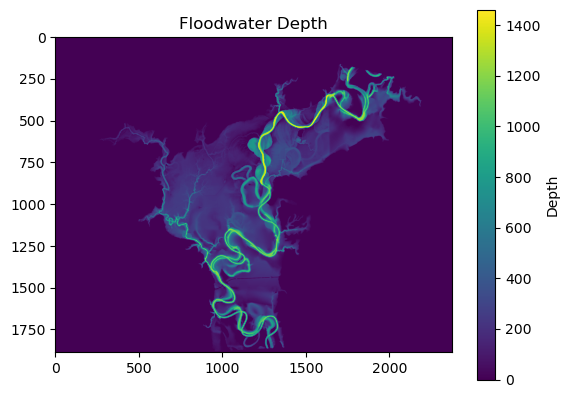

In [2]:
   import numpy as np
   from PIL import Image
   import matplotlib.pyplot as plt

   # Otwórz obraz
   im = Image.open("C:/Users/Stanislav/OneDrive/Pulpit/Data Science and Licencjat/Licencjat/FLEXTH/testowanie/output/WD_flood_method_A_Smax_0.1_Nmax_200_a_1_Sbs_0_Dmax_10_A12_10_gaps_0.1_unrestricted_False.tif")

   # Konwersja do tablicy NumPy
   imarray = np.array(im)

   # Wizualizacja danych
   plt.imshow(imarray, cmap='viridis')  # Możesz wybrać różne kolory np. 'viridis', 'plasma'
   plt.colorbar(label='Depth')  # Dodaj pasek kolorów z etykietą
   plt.title('Floodwater Depth')
   plt.show()

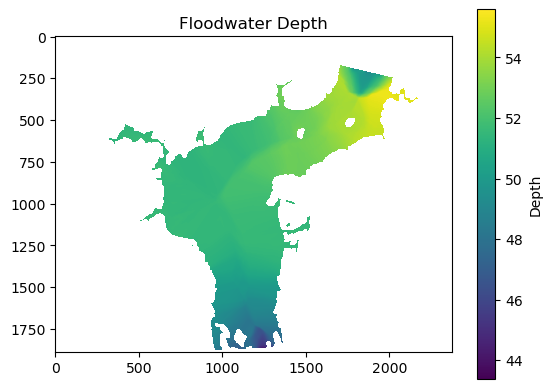

In [3]:
   import numpy as np
   from PIL import Image
   import matplotlib.pyplot as plt

   # Otwórz obraz
   im = Image.open("C:/Users/Stanislav/OneDrive/Pulpit/Data Science and Licencjat/Licencjat/FLEXTH/testowanie/output/WL_flood_method_A_Smax_0.1_Nmax_200_a_1_Sbs_0_Dmax_10_A12_10_gaps_0.1_unrestricted_False.tif")

   # Konwersja do tablicy NumPy
   imarray = np.array(im)

   # Wizualizacja danych
   plt.imshow(imarray, cmap='viridis')  # Możesz wybrać różne kolory np. 'viridis', 'plasma'
   plt.colorbar(label='Depth')  # Dodaj pasek kolorów z etykietą
   plt.title('Floodwater Depth')
   plt.show()

Średnia różnica: -273.4627157705762
Maksymalna różnica: 1445.3430290222168
Odchylenie standardowe różnicy: 270.47293422585767


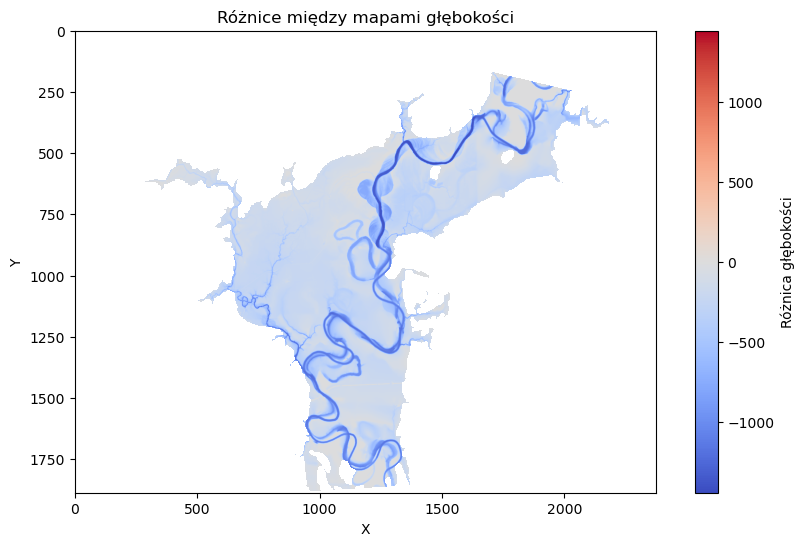

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Ścieżki do plików TIFF
path_estimated = "C:/Users/Stanislav/OneDrive/Pulpit/Data Science and Licencjat/Licencjat/FLEXTH/testowanie/output/WD_flood_method_A_Smax_0.1_Nmax_200_a_1_Sbs_0_Dmax_10_A12_10_gaps_0.1_unrestricted_False.tif"
path_actual = "C:/Users/Stanislav/OneDrive/Pulpit/Data Science and Licencjat/Licencjat/Dane/Brazos_hydraulic_simulation/brazos_basement_water_depth.tif"

def load_and_mask_nodata(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        nodata = src.nodata
        if nodata is not None:
            data = np.where(data == nodata, np.nan, data)
    return data

# Załaduj obrazy TIFF i zamaskuj wartości NoData
data1 = load_and_mask_nodata(path_actual)
data2 = load_and_mask_nodata(path_estimated)

# Sprawdź, czy obrazy mają te same wymiary
if data1.shape != data2.shape:
    raise ValueError("Obrazy mają różne wymiary!")

# Oblicz różnice, ignorując NaN
difference = np.subtract(data1, data2)

# Oblicz statystyki różnic, ignorując NaN
mean_difference = np.nanmean(difference)
max_difference = np.nanmax(np.abs(difference))
std_difference = np.nanstd(difference)

print(f"Średnia różnica: {mean_difference}")
print(f"Maksymalna różnica: {max_difference}")
print(f"Odchylenie standardowe różnicy: {std_difference}")

# Wizualizacja różnic
plt.figure(figsize=(10, 6))
plt.imshow(difference, cmap='coolwarm', vmin=-max_difference, vmax=max_difference)
plt.colorbar(label='Różnica głębokości')
plt.title('Różnice między mapami głębokości')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
